#### copyright: Ford Motor Company

In [1]:
import pandas as pd
import numpy as np
from scipy import sparse

from nltk.stem import WordNetLemmatizer

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, StandardScaler, LabelEncoder
#from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin


from xgboost import XGBClassifier
import xgboost as xgb

from datetime import datetime
from datetime import date

import re
import pickle

In [2]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import preprocessing
from sklearn import metrics

In [ ]:
import gensim
from gensim.models import Word2Vec
from gensim.models.doc2vec import TaggedDocument

In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [4]:
import nltk
from nltk.corpus import stopwords                   #Stopwords corpus
from nltk.tokenize import word_tokenize

In [5]:
stop_words = stopwords.words('english')

In [21]:
df_tmp = pd.read_csv('C:/Projects/FCSD/FNOP/old/Traindata_pilot_sample_v0.csv', engine='python')

In [22]:
df_1 = df_tmp[['cust_txt', 'target']]

In [82]:
### create count by target df
target_count_df = df_1.groupby('target')['cust_txt'].count().to_frame(name='row_count').reset_index()

### Experiment 1: using tfidf to cluster

In [73]:
text_input_df = pd.read_csv("C:/Projects/FCSD/FNOP/old/processed_cust_txt.csv")

In [74]:
text_input_df.loc[text_input_df['process_txt'].isnull()==True,].head(5)

process_txt
379          NaN
1411         NaN
1719         NaN
2480         NaN
2520         NaN

In [76]:
#### there are 391 lines with processed text of ''
text_input_df.loc[text_input_df['process_txt'].isnull()==True,].shape

(391, 1)

In [7]:
### convert null values of customer_txt into ' '
text_input_df.loc[text_input_df['process_txt'].isnull()==True,'process_txt'] = ' '

In [8]:
vectorizer = TfidfVectorizer(ngram_range=(2,3), max_features = 8000)

In [9]:
tfidf_matrix = vectorizer.fit_transform(text_input_df['process_txt'])

In [10]:
def find_optimal_clusters(data, init_k, max_k, step_k):
    iters = range(init_k, max_k+1, step_k)
    
    sse = []
    for k in iters:
        ### The inertia is defined as the sum of square distances of samples to their nearest neighbor.
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

Fit 10 clusters
Fit 20 clusters
Fit 30 clusters
Fit 40 clusters
Fit 50 clusters
Fit 60 clusters
Fit 70 clusters
Fit 80 clusters
Fit 90 clusters
Fit 100 clusters


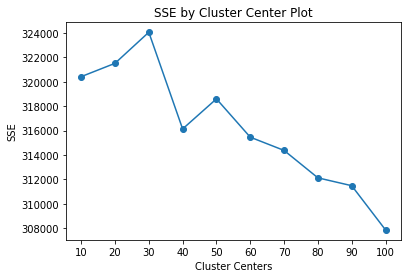

In [11]:
find_optimal_clusters(tfidf_matrix, 10, 100, 10)

Fit 70 clusters
Fit 72 clusters
Fit 74 clusters
Fit 76 clusters
Fit 78 clusters
Fit 80 clusters
Fit 82 clusters
Fit 84 clusters
Fit 86 clusters
Fit 88 clusters
Fit 90 clusters
Fit 92 clusters
Fit 94 clusters
Fit 96 clusters
Fit 98 clusters
Fit 100 clusters


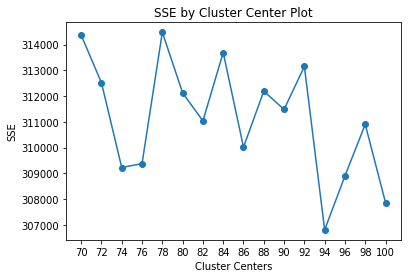

In [12]:
find_optimal_clusters(tfidf_matrix, 70, 100, 2)

#### use 74 clusters

In [133]:
kmeans_74 = MiniBatchKMeans(n_clusters=74, init_size=1024, batch_size=2048, random_state=20).fit(tfidf_matrix)

In [134]:
clusters = kmeans_74.fit_predict(tfidf_matrix)

In [57]:
tfidf_dense = tfidf_matrix.todense()

In [60]:
features = vectorizer.get_feature_names()

In [15]:
### get the top keywords from each cluster
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(tfidf_matrix, clusters, vectorizer.get_feature_names(), 10)


Cluster 0
washer inoperable,high setting,high set,windshield wiper,windshield wiper work,high speed,work high speed,wiper work,wiper work high,work high

Cluster 1
inoperable blow,air condition,start blow,start blow warm,inoperable blow warm,ac blow,ac blow warm,blow warm air,warm air,blow warm

Cluster 2
vehicle coolant,vehicle coolant leak,add gallon,add water,leak add,coolant leak add,leak coolant,coolant leak coolant,leak coolant leak,coolant leak

Cluster 3
message come,hear sound,engine light car,car tow,vehicle heat,fill coolant,heat work,e23 engine,vehicle tow,car heating

Cluster 4
vehicle start,camera display,key come,remote work,speaker work,ac cold,around mph,one remote,turn turn,half time

Cluster 5
battery low,one key,one key fob,fob battery,key fob battery,key fob work,fob work,key fob inoperable,fob inoperable,key fob

Cluster 6
make click,click dash,click noise dash,control switch,floor vent,click noise,noise dash,defrost vent,defrost floor,switch defrost

Cluster 7
l

In [135]:
clusters[:30]

array([11, 11, 64, 64, 11, 11, 64, 64, 11, 11, 11, 11, 62, 11, 64, 11, 64,
       11, 11, 46, 11, 11, 11, 64, 11, 11, 62, 11, 11, 11])

In [136]:
### the customer text with no information is clustered into cluster 11, which could have almost all 0 in the matrix
clusters[2480]

11

In [18]:
cluster_assign = kmeans_74.labels_

In [19]:
cluster_assign_df = pd.DataFrame(cluster_assign, columns = ['cluster_id'])

In [23]:
cluster_compare_df = pd.concat([df_1[['target']], cluster_assign_df], axis = 1)

In [83]:
cluster11_target_count_df = cluster_compare_df.loc[lambda df: df['cluster_id']==11, ].groupby('target')['cluster_id'].count().to_frame(name='row_count').reset_index()

In [88]:
### merge original target count with cluster target count
merged_target_count_df = target_count_df.merge(cluster11_target_count_df, 'left', on='target').fillna(0)

In [89]:
merged_target_count_df['cluster_ratio']=merged_target_count_df['row_count_y']/merged_target_count_df['row_count_x']

### iterate through the entire clusters and print dominating parts

In [93]:
cluster_name_list = list(set(clusters))

In [105]:
cluster_analysis_df = pd.DataFrame()
for c in cluster_name_list:
    cluster_target_count_df = cluster_compare_df.loc[lambda df: df['cluster_id']==c, ].groupby('target')['cluster_id'].count().to_frame(name='row_count').reset_index()
    merged_target_count_df = target_count_df.merge(cluster_target_count_df, 'left', on='target').fillna(0)
    merged_target_count_df['cluster_ratio']=merged_target_count_df['row_count_y']/merged_target_count_df['row_count_x']
    top_1_per_cluster = merged_target_count_df.sort_values('cluster_ratio', ascending=False).iloc[:1,:]
    top_1_per_cluster['cluster_id'] = c
    cluster_analysis_df = pd.concat([cluster_analysis_df, top_1_per_cluster], ignore_index=True)

In [106]:
cluster_analysis_df.to_csv("C:/Projects/FCSD/FNOP/old/tfidf_bi_trigram_74_clusters_top1.csv", index=False)

### Experiment 2: KMeans on gensim doc2vec

#### text preprocessing (do not remove stop words and keep puctuations, convert document to vectors)

In [ ]:
lookup_table = 'C:/Projects/FCSD/FNOP/old/Misspellings_Correction_Synonyms_Lookup_Table_Master.xlsx'

In [ ]:
syn_df=pd.read_excel(lookup_table)
syn_df = syn_df[syn_df['Review'] != "D"]
syn_dict=dict(zip(syn_df.misspelled, syn_df.corrected))

In [ ]:
def TextPreprocess(text):
        # Avoid mixed data type errors and apply str on all rows
        # convert to lower case
        text = str(text).lower()

        #Remove HTML Tags
        text = re.sub('<[^>]*>', '', text)
        r1 = re.compile('<.*?>')
        text = re.sub(r1, ' ', text)

#         # Remove any token with numbers and/or special characters
#         r2 = re.compile(r'^[0-9\W\_]+$')
#         text = re.sub(r2, ' ', text)
        
        # move parenthesis content to the end of paragraph
        paren_content_extract = re.compile(r'\(([^()]+)\)')
        p_cont = paren_content_extract.findall(text)
        text = re.sub(r'\([^()]*\)', ' ', text)
        text = text + '. '.join(p_cont) + '.'
        
        # hard code to convert abbreviations with \'s
        text = re.sub(r"what's", "what is ", text)
        text = re.sub(r"\'s", " ", text)
        text = re.sub(r"\'ve", "have not ", text)
        text = re.sub(r"can't", "can not ", text)
        text = re.sub(r"n't", " not ", text)
        text = re.sub(r"i'm", "i am ", text)
        text = re.sub(r"\'re", " are ", text)
        text = re.sub(r"\'d", " would ", text)
        text = re.sub(r"\'ll", " will ", text)
        text = re.sub(r"\'scuse", " excuse ", text)
        
        # if a token starts with numerical or # sign, remove it
        text = re.sub('\b[\d#]+\S*\b', ' ', text)
        # if a token ends with numberical, remove it
        text = re.sub(r'\b\S+\d+\b', ' ', text)

#         #Removing Punctuations
#         text = re.sub(r'[?|!|\'|"|#]',r'',text)
#         text = re.sub(r'[.|,|)|(|\|/]',r' ',text)     

        #Removing Punctuations
        text = re.sub(r'[\'|"|#]',r'',text)
        text = re.sub(r'[)|(]',r' ',text) 
        
        # whitespace characters are replaced into space, multiple dots replaced into single dot
        text = re.sub('\s+', ' ', text)
        text = re.sub(r'\.+', '.', text)

        # Tokenize all text data using nltk package
        text = word_tokenize(text)

#         # Remove stop words
#         stop = stopwords.words('english')
#         stop1 = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z', \
#                  'c/s','c/states','c/stated','cu', 'cs','c-s', 'cus','tomer', 'stomer', 'tate', 'cust',  'cust states', \
#                  'advise','nana','NaN','customer','states','rr','nan','wont','ck','check','pls','please', 'client','owner']

#         # Combine default nltk stop list and custom stop list to generate a deduplicated list
#         english_stops = list(set(stop+stop1))

#         text = [item for item in text if item not in english_stops]

#         # Remove special characters occuring as prefixes
#         text = [re.sub(r'^[\W\_]+','',str(i)) for i in text]
#         # Remove special characters occuring as suffixes
#         text = [re.sub(r'[\W\_]+$','',str(i)) for i in text]

#         # Replace special characters with spaces when occuring within the token 
#         #(i.e. not at the beginning or the end) only for tokens greater than 5 characters in length
#         text =[re.sub(r'[\W\_]+', ' ', str(i)) if len(str(i)) > 5 else i for i in text]

#         # Replace special characters with null when occuring within the token 
#         #(i.e. not at the beginning or the end) only for tokens less than 6 characters in length
#         text = [re.sub(r'[\W\_]+', '', str(i)) if len(str(i)) < 6 else i for i in text]

#         # Remove stop words after data cleansing steps to remove any residual stop words
#         text = [item for item in text if item not in english_stops]

#         # remove any numbers after data cleansing steps to remove any residual numeric values
#         r3 = re.compile(r'^[0-9\W\_]+$')
#         text = [i for i in text if not r3.match(i)]

        #Perform synonym lookup to find matching correctly spelled tokens for misspelled tokens
        #spell=SpellChecker() 
        text = [syn_dict.get(str(i), str(i)) for i in text]

        # Convert the list to string before passing to lemmatization module
        text = ' '.join(text)

#         # Perform Lemmatization on the cleaned up data before tfidf vectorization
#         text = lemmatize_with_postag(text)
        text = text.replace(' .', '.').replace(' ?', '?').replace(' !', '!').replace(' ,', ',').replace(' /', '/')
        return(text)

In [ ]:
df_1['process_txt']=df_1['cust_txt'].apply(lambda x: TextPreprocess(x))

In [ ]:
### turn text into tokens
X_train = [word_tokenize(doc) for doc in df_1['process_txt']]

In [ ]:
### use doc2vec to get doc embedding
train_corpus = []
for i in range(len(X_train)):
    train_corpus.append(gensim.models.doc2vec.TaggedDocument(X_train[i], [i]))

In [ ]:
doc2vec_model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)

In [ ]:
doc2vec_model.build_vocab(train_corpus)

In [ ]:
doc2vec_model.train(train_corpus, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

#### store the inferred vector into a numpy arrary

In [ ]:
doc_vector_array = []
for doc_id in range(len(train_corpus)):
    inferred_vector = doc2vec_model.infer_vector(train_corpus[doc_id].words)
    doc_vector_array.append(inferred_vector)

In [ ]:
column_names = ['col'+str(i) for i in range(50)]

In [ ]:
doc_embedding = pd.DataFrame(doc_vector_array, columns = column_names)

In [110]:
normalized_embedding = preprocessing.normalize(doc_embedding)

In [123]:
column_names = ['col'+str(i) for i in range(50)]

In [124]:
pd.DataFrame(normalized_embedding, columns = column_names).to_csv("C:/Projects/FCSD/FNOP/old/gensim_doc_embedding_normalized.csv", index=False)

#### apply KMeans to normalized embeddings

Fit 10 clusters
Fit 20 clusters
Fit 30 clusters
Fit 40 clusters
Fit 50 clusters
Fit 60 clusters
Fit 70 clusters
Fit 80 clusters
Fit 90 clusters
Fit 100 clusters


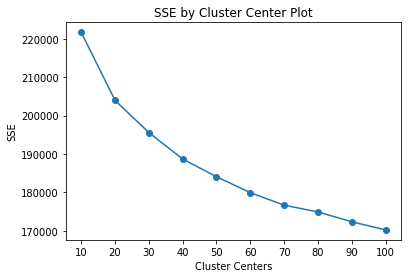

In [125]:
find_optimal_clusters(normalized_embedding, 10, 100, 10)

Fit 80 clusters
Fit 82 clusters
Fit 84 clusters
Fit 86 clusters
Fit 88 clusters
Fit 90 clusters
Fit 92 clusters
Fit 94 clusters
Fit 96 clusters
Fit 98 clusters
Fit 100 clusters


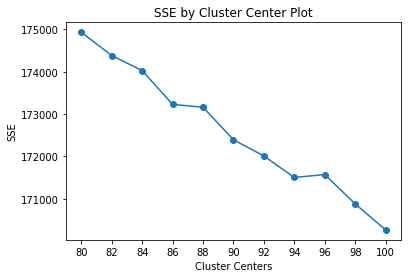

In [126]:
find_optimal_clusters(normalized_embedding, 80, 100, 2)

In [127]:
kmeans_86 = MiniBatchKMeans(n_clusters=86, init_size=1024, batch_size=2048, random_state=20).fit(normalized_embedding)
cluster_assign = kmeans_86.labels_

In [128]:
sil_score_86 = metrics.silhouette_score(normalized_embedding, cluster_assign, metric = 'euclidean')

In [129]:
sil_score_86

0.02453875804940354

In [131]:
clusters_gensim = kmeans_86.fit_predict(normalized_embedding)

In [132]:
clusters_gensim[:30]

array([18, 70, 72, 41, 69,  7, 72, 72, 72, 72, 74, 46, 56, 30, 37, 15, 72,
       13, 66, 36, 66, 32, 30, 72, 35,  7, 82, 57, 55, 47])